In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker
from scipy.stats import t
import math

Matplotlib is building the font cache; this may take a moment.


In [2]:
data = pd.read_csv("./parallelize_speedup_limit_test.csv")

# Calculate the overall runtime = time spent in CT + GA + CA
data['overall_runtime'] = \
    data['CT_runtime'] + data['GA_runtime'] + data['CA_runtime']

In [3]:
# Calculate statistics for each network and for each number of threads 
# tested
grouped_data = \
    data \
        .groupby(['network', 'num_threads']) \
        .agg({
            "num_threads": ['count'],
            "GA_runtime": ['mean', 'std'],
            "CA_runtime": ['mean', 'std'],
            "overall_runtime": ['mean', 'std']
        })

# Compressing the column levels and rename some volumes to more
# sensible headings
grouped_data.columns = \
    grouped_data.columns.get_level_values(0) + "_" + \
    grouped_data.columns.get_level_values(1)
    
grouped_data = \
    grouped_data \
        .reset_index()\
        .rename(columns={'num_threads_count':'num_samples'})

# Calculate the 95% CI width x (i.e. the 95% CI will be [-x, x]) 
# based on the std dev. and sample size
def calculate_95_CI_pos_val(stdev, n):
    return stdev / np.sqrt(n) * t.ppf(0.95, n-1)

grouped_data['GA_runtime_95_CI'] = \
    grouped_data.apply(
        lambda x: calculate_95_CI_pos_val(x['GA_runtime_std'], 
                                          x['num_samples']),
        axis=1)

grouped_data['CA_runtime_95_CI'] = \
    grouped_data.apply(
        lambda x: calculate_95_CI_pos_val(x['CA_runtime_std'], 
                                          x['num_samples']),
        axis=1)
    
grouped_data['overall_runtime_95_CI'] = \
    grouped_data.apply(
        lambda x: calculate_95_CI_pos_val(x['overall_runtime_std'], 
                                          x['num_samples']),
        axis=1)

<Figure size 432x288 with 0 Axes>

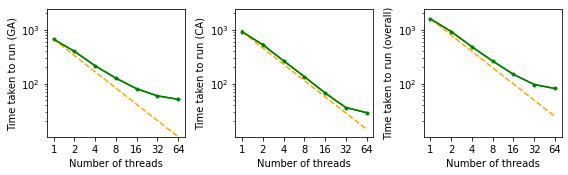

<Figure size 432x288 with 0 Axes>

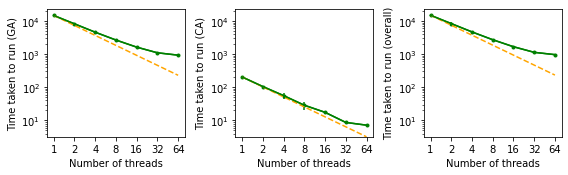

<Figure size 432x288 with 0 Axes>

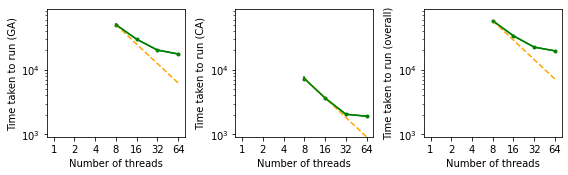

<Figure size 432x288 with 0 Axes>

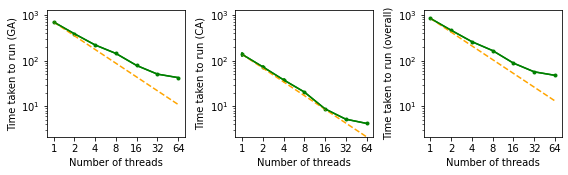

In [4]:
# Create a runtime vs num. threads in log-log scale,
# one plot for each network and for each of {GA, CA, Overall} runtime.

networks = ['amazon', 'youtube', 'lj', 'dblp']
stages = ['GA', 'CA', 'overall']

for network in networks:
    
    plt.clf()
    fig = plt.figure(figsize=(8, 2.5))
    
    target_network = grouped_data[grouped_data['network'] == network]
    
    for category in stages:
        
        ax = fig.add_subplot(1, 3, stages.index(category) + 1)

        # The actual runtime from experiments
        ax.plot(target_network['num_threads'], 
                target_network[category + '_runtime_mean'],
                color='green', ls='-', marker = '.')
        
        # The ideal runtime (assuming doubling the number of threads will
        # halve the runtime)
        ax.plot(target_network['num_threads'], 
                np.max(target_network[category + '_runtime_mean']) / 
                    (target_network['num_threads'] / 
                     np.min(target_network['num_threads'])),
                color='orange', ls='--')
        
        # The error bar on the actual runtime
        ax.errorbar(target_network['num_threads'], 
                    target_network[category + '_runtime_mean'], 
                    target_network[category + '_runtime_95_CI'],
                    color='green')

        ax.set_xscale('log')
        ax.set_xticks([1, 2, 4, 8, 16, 32, 64])
        ax.set_xlim(0.8, 80)
        ax.get_xaxis().set_major_formatter(
            matplotlib.ticker.ScalarFormatter())
        ax.get_xaxis().set_tick_params(which='minor', size=0)
        ax.get_xaxis().set_tick_params(which='minor', width=0) 

        # Leave some padding on both ends of the y-axis, but not too much
        ylim_low = min(np.max(target_network['CA_runtime_mean']), 
                       np.max(target_network['GA_runtime_mean'])) / \
                   (max(target_network['num_threads']) / 
                       np.min(target_network['num_threads']))
        ylim_high = np.max(target_network['overall_runtime_mean']) * 1.5
        
        ax.set_yscale('log')
        ax.set_yticks([10, 100, 1000, 10000, 100000])
        ax.set_ylim(ylim_low, ylim_high)

        ax.set_xlabel('Number of threads')
        ax.set_ylabel('Time taken to run (' + category + ')')
        
    plt.tight_layout()
        
    plt.show()
#     plt.savefig("./figures/parallelize_speedup_limit_test_" + 
#                 network + ".pdf",
#                 bbox_inches='tight', transparent=True)
